In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1

Что влияет на ошибку второго рода при проведении A/B эксперимента?

- [+] Выбор статистического критерия
- [+] Количество наблюдений или продолжительность эксперимента
- [+] Размер дисперсии в метрике
- [+] Величина эффекта (изменение в метрике между контрольной и тестовой группой)

Всё из этого влияет на ошибку второго рода (или мощность).

### 2

Чем больше дисперсия нашей метрики, тем сложнее детектировать статистически значимое отклонение, но как они связаны?

Как соотносится длина доверительного интервала (когда мы считаем по формуле, например, используя t-статистику) с дисперсией случайной величины?

- Длина интервала прямо пропорциональна дисперсии
- Длина интервала обратно пропорциональна квадратному корню из дисперсии
- [+] Длина интервала прямо пропорциональна квадратному корню из дисперсии
- Длина интервала связана с дисперсии неизвестным законом

**Комментарий**

В формулу для доверительного интервала входит среднеквадратичное отклонение (квадратный корень из дисперсии) в числителе. То есть зависимость прямо пропорциональная квадратному корню из дисперсии.

$$\left(\overline{X} - t_{N-1, 1-\frac{\alpha}{2}} \frac{S}{\sqrt{N}} , \overline{X} + t_{N-1, 1 - \frac{\alpha}{2}} \frac{S}{\sqrt{N}} \right)$$

### 3

Уменьшение дисперсии — основной способ увеличить мощность при проведении A/B эксперимента, если нельзя увеличить продолжительность эксперимента. Один из основных методов для этого — CUPED.

Представим, что мы проводим эксперимент по пользователям и метрики у нас по каждому пользователю.

В чём идея CUPED для уменьшения дисперсии метрик?

- Мы объединяем пользователей в группы похожих, чтобы перейти к новой групповой метрике с меньшей дисперсией
- [+] Мы используем поведение каждого пользователя, чтобы перейти к метрики с меньшей дисперсией за счёт поведения пользователя до эксперимента
- Мы оцениваем распределение метрики внутри группы, чтобы перейти к метрике с меньшей дисперсией

**Комментарий**

Идея CUPED как раз в том, чтобы сделать преобразование метрики по каждому пользователю с учётом его персональных особенностей.

### 4

Почему в CUPED в качестве признака, с помощью которого уменьшается дисперсия исходной метрики, берётся та же метрика за период, предыдущий до эксперимента?

- [+] Метрика, взятая за период до эксперимента, гарантировано не аффектится разбиением в эксперименте
- Нельзя брать ничего, кроме той же самой метрики для этого преобразования
- Мы должны использовать метрику, измеряемую в тех же единицах
- [+] Та же метрика, хоть и за другой период, наиболее коррелирует с нашей исходной метрикой

**Комментарий**

У CUPED есть требование, чтобы сам признак не был зааффекчен разбиением пользователей. Чтобы это гарантировать (и не проверять как-то специально), проще взять данные за период до эксперимента. В остальном эффект достигается за счёт корреляции с исходным признаком, поэтому удобнее брать не посторонний признак, а ту же самую метрику. Тем самым мы как раз вычитаем то, как пользователь ведёт себя обычно.

### 5

Попробуем применить CUPED на практике на синтетических данных (на реальных, конечно, эффект будет не таким большим).

...

В нём мы генерируем нашу метрику «трат» для 2-х групп пользователей так, что исходная привычка распределена логнормально, а в наших периодах до и во время эксперимента с некоторым нормальным отклонением от привычки каждого пользователя. При этом в тестовом периоде люди тратят больше.

Примените к этим данным CUPED и посчитайте, во сколько раз уменьшилась дисперсия в вашей выборке.

**Решение**

Загрузим данные (кодом из задания)

In [2]:
users_num = 10000

df = pd.DataFrame()
df['user'] = range(users_num)
df['group'] = np.random.rand(users_num) < 0.5

df['user_mean'] = np.random.lognormal(mean=np.log(1000), sigma=0.5, size=users_num)
df['cost_before'] = np.abs(
    df['user_mean'] + np.random.normal(0, 100, size=users_num)
)
df['cost'] = np.abs(
    df['user_mean'] + np.random.normal(50, 100, size=users_num)
)

<AxesSubplot:>

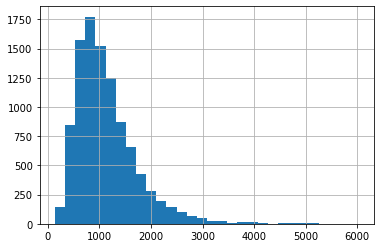

In [3]:
df.user_mean.hist(bins=30)

 Посчитаем коэффициент для CUPED:

In [4]:
theta = np.cov(df['cost'], df['cost_before'])[0, 1] / np.var(df['cost_before'])
theta

0.969514748011837

Посчитаем новую метрику:

In [5]:
df['cost_cuped'] = (
    df['cost'] -
    theta * (df['cost_before'] - np.mean(df['cost_before']))
)

Посчитаем дисперсию:

In [6]:
np.var(df[df.group == 0].cost), np.var(df[df.group == 1].cost)

(370260.7581196701, 359347.70419003954)

In [7]:
np.var(df[df.group == 0].cost_cuped), np.var(df[df.group == 1].cost_cuped)

(20005.43110745511, 19414.570572201937)

Видим, что уменьшилось примерно в 20 раз (из 360к в 19к).

### 6

В чём идея бутстрэпа при измерении CTR в A/B экспериментах?

- Мы генерируем псевдовыборки пользователей, оцениваем число кликов в каждой из групп, повторяем процедуру много раз, тем самым получая бутстрэп-распредение, по которому можно оценить значимость
- Мы генерируем пвседовыборки кликов пользователей, оцениваем CTR в каждой из групп, повторяем процедуру много раз, тем самым получая бутстрэп-распредение, по которому можно оценить значимость
- Мы генерируем псевдовыборки пользователей, оцениваем CTR в каждой из групп как средний CTR пользователей, повторяем процедуру много раз, тем самым получая бутстрэп-распредение, по которому можно оценить значимость
- [+] Мы генерируем псевдовыборки пользователей, оцениваем CTR в каждой из групп как отношение суммы кликов к сумме показов, повторяем процедуру много раз, тем самым получая бутстрэп-распредение, по которому можно оценить значимость

**Комментарий**

Важно, что если мы хотим с помощью бутстрэпа оценить изменение ratio-метрики, то нам надо оценивать групповой CTR, то есть делить общее число кликов на общее число показов в рамках группы. Если же просто усреднять CTR всех пользователей, то мы будем применять обычный бутстрэп, мощность которого будет ниже.

### 7

В чём идея бакетирования при анализе изменения CTR-метрик?

- Мы переходим от исходных пользователей к бакетам, для которых рассчитываем групповой CTR, далее сравниваем CTR бакетов между двумя группами бутстрэпом
- Мы сэмплируем клики пользователей в разные бакеты, для которых рассчитываем групповой CTR, далее сравниваем CTR бакетов между двумя группами бутстрэпом
- [+] Мы переходим от исходных пользователей к бакетам, для которых рассчитываем групповой CTR, далее сравниваем CTR бакетов между двумя группами привычными статистическими критериями
- Мы переходим от исходных пользователей к бакетам, для которых рассчитываем CTR как средний CTR пользователей бакета, далее сравниваем CTR бакетов между двумя группами привычными статистическими критериями

**Комментарий**

Важно, что мы переходим к CTR бакетов, а дальше не обязательно должны применять бутстрэп — можно применять любой из привычных статистических критериев. 

### 8

Давайте практиковаться в бакетном тестирование, а заодно проверим, как будет различаться дисперсия CTR в бакете, если считать её двумя способами. 

Сделайте переход к бакетам (возьмём 100 штук), с помощью md5 кэша с солью, применённой к айдишнику пользователя (от соли результат сильно различаться не будет, но можете взять 'my_salt').

Далее посчитайте два вида CTR: групповой (на основе количества кликов и просмотров в бакете) и обычный средний CTR пользователей в бакете (это нужно, чтобы мы сравнивали выборки одинаковых длин). Посчитайте среднеквадратичное отклонение этих CTR и сравните по одной из групп значения между этими способами.

**Решение**

Сгенерируем данные кодом из задания:

In [8]:
np.random.seed(6)

users_num = 10000
mean_user_ctr = 0.2
beta = 20
alpha = mean_user_ctr * beta / (1 - mean_user_ctr)

df = pd.DataFrame()
df['user'] = range(users_num)
df['group'] = np.random.rand(users_num) < 0.5

df['base_user_ctr'] = np.random.beta(alpha, beta, size=users_num)
df['views'] = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
df['clicks'] = np.random.binomial(df['views'], df['base_user_ctr'])

Посчитаем CTR по пользователям:

In [9]:
df['ctr'] = df['clicks'] / df['views']

Посчитаем CTR по бакетам:

In [10]:
import hashlib

df['bucket'] = df['user'].apply(
    lambda x: int(hashlib.md5((str(x) + 'my_salt').encode()).hexdigest(), 16) % 100
)

In [11]:
new_df = df.groupby(['group', 'bucket']).sum(['views', 'clicks']).reset_index()
new_df['ctr'] = new_df.clicks / new_df.views

new_df.head()

,group,bucket,user,base_user_ctr,views,clicks,ctr
0,False,0,227008,7.831370,178,28,0.157303
1,False,1,249159,10.306703,249,48,0.192771
2,False,2,195698,9.296231,249,51,0.204819
3,False,3,170640,9.860107,216,53,0.245370
4,False,4,246366,9.552937,244,41,0.168033


Оценим среднеквадратичное отклонение группового CTR по бакетам по одной из групп:

In [12]:
new_df[new_df.group == False].ctr.std()

0.027226170764098546

Посчитаем CTR бакетов как средний CTR по пользователям:

In [13]:
new_df = df.groupby(['group', 'bucket']).mean(['ctr']).reset_index()

new_df.head()

,group,bucket,user,base_user_ctr,views,clicks,ctr
0,False,0,5536.780488,0.191009,4.341463,0.682927,0.172779
1,False,1,4983.180000,0.206134,4.980000,0.960000,0.168367
2,False,2,4163.787234,0.197792,5.297872,1.085106,0.175174
3,False,3,3709.565217,0.214350,4.695652,1.152174,0.303238
4,False,4,5027.877551,0.194958,4.979592,0.836735,0.163224


Оцениваем среднеквадратичное для этих бакетов:

In [14]:
new_df[new_df.group == False].ctr.std()

0.034160430992764335

Видим, что в таком случае разброс больше (то есть у бакетов лучше с групповым CTR)

### 9

Отметьте верные утверждения о технике линеаризации

- [+] Линеаризованный CTR приближает метрику к 0 по сравнению с обычным CTR пользователя
- Новая метрика пользователя зависит только от его исходных показателей
- После линеаризации метрика становится бинарной
- [+] При линеаризации сохраняется размер выборки, если исходная выборка была по пользователям